In [1]:
import glob
import rasterio
from pathlib import Path
import os
import reverse_geocoder as rg
import pyproj
import geopandas as gpd
import sys

In [2]:
if Path.cwd().name != 'src':
    os.chdir('/home/vaschetti/maxarSrc/src')
from my_functions import build

In [3]:
from my_functions import build
events_names = build.get_all_events()
events_names

['southafrica-flooding22',
 'Kalehe-DRC-Flooding-5-8-23',
 'shovi-georgia-landslide-8Aug23',
 'Emilia-Romagna-Italy-flooding-may23',
 'src',
 'NWT-Canada-Aug-23',
 'Libya-Floods-Sept-2023',
 'Gambia-flooding-8-11-2022',
 'New-Zealand-Flooding23',
 'Hurricane-Fiona-9-19-2022',
 'Hurricane-Idalia-Florida-Aug23',
 'Hurricane-Ian-9-26-2022',
 'yellowstone-flooding22',
 'pakistan-flooding22',
 'Morocco-Earthquake-Sept-2023',
 'Indonesia-Earthquake22',
 'cyclone-emnati22',
 'Kahramanmaras-turkey-earthquake-23',
 'test_folder',
 'Marshall-Fire-21-Update',
 'metadata',
 'India-Floods-Oct-2023',
 'Maui-Hawaii-fires-Aug-23',
 'tonga-volcano21',
 'BayofBengal-Cyclone-Mocha-May-23',
 'Sudan-flooding-8-22-2022']

In [4]:
evento = build.Event('Gambia-flooding-8-11-2022', when='pre')
print(evento.region_name)
all_mosaics_names = evento.all_mosaics_names
print(all_mosaics_names)
m0 = evento.mosaics[all_mosaics_names[0]]
print(f'Number of tiles: {m0.tiles_num}')


AfricaWest-Full
['10300100CFC9A500', '105001002BD68F00', '1040010073D77D00']
Number of tiles: 18


In [5]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Type, Union
from torchgeo.datasets.utils import _list_dict_to_dict_list

def my_stack_samples(samples: Iterable[dict[Any, Any]]) -> dict[Any, Any]:
    """Stack a list of samples along a new axis.

    Useful for forming a mini-batch of samples to pass to
    :class:`torch.utils.data.DataLoader`.

    Args:
        samples: list of samples

    Returns:
        a single sample

    .. versionadded:: 0.2
    """
    print('##############')
    print(len(samples))
    print(samples[0].keys())
    collated: dict[Any, Any] = _list_dict_to_dict_list(samples)
    print('######collated######')
    print(collated['crs'])
    print('######end_collated######')
    for key, value in collated.items():
        if isinstance(value[0], Tensor):
            collated[key] = torch.stack(value)
    return collated

In [43]:
import rasterio
from rasterio.windows import Window
from my_functions import geoDatasets
from my_functions.samplers import MyGridGeoSampler, MyBatchGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import matplotlib.pyplot as plt
from tqdm import tqdm

def segment_tile(self, tile_path):
    batch_size = 4
    dataset = geoDatasets.Maxar(str(tile_path))
    sampler = MyBatchGridGeoSampler(dataset, batch_size=batch_size, size=100, stride=100)
    print(len(sampler))
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)
    print(len(dataloader))
    print(dataset.res)
    for batch in tqdm(dataloader):
        #print(batch.keys())
        #samples_list = unbind_samples(batch)
        #print(samples_list)
        #img_batch = batch['image']
        #print(type(img_batch))
        
        #Le immagini sono già RGB
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8')
        #fig, axs = plt.subplots(1, batch_size, figsize=(30, 30))
        #for i in range(batch_size):
        #    axs[i].imshow(img_b[i])
        #print(img_b.shape)
        break
    return img_b

img_b = segment_tile(evento, m0.tiles_paths[0])

7657
7657
0.30517578125


  0%|          | 0/7657 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315457.45849609375 1490156.25, 320156.25 1490156.25, 320156.25 1484843.75, 315425.4150390625 1484843.75, 315457.45849609375 1490156.25))


In [42]:
m0.dataset_res

AttributeError: 'Mosaic' object has no attribute 'dataset_res'

In [25]:
img_b.shape

(4, 100, 100, 3)

In [49]:
import numpy as np
from my_functions import segment
from groundingdino.util.inference import predict as GD_predict
from groundingdino.util.inference import load_model as GD_load_model

def get_gdino_boxes(img_batch: np.array,
                    GDINO_model,
                    TEXT_PROMPT,
                    BOX_TRESHOLD,
                    TEXT_TRESHOLD,
                    dataset_res,
                    max_area_mt2 =3000):
    all_tree_boxes4Sam = []
    for img in img_batch:
        image_transformed = segment.dino_img_load(img)
        tree_boxes, logits, phrases = GD_predict(GDINO_model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
        tree_boxes4Sam = []
        if len(tree_boxes) != 0:
            sample_size = image_transformed.shape[-1]
            keep_ix_tree_boxes = segment.filter_on_box_area_mt2(tree_boxes, sample_size, dataset_res, max_area_mt2 = max_area_mt2)
            tree_boxes4Sam = segment.GDboxes2SamBoxes(tree_boxes[keep_ix_tree_boxes], sample_size)
            all_tree_boxes4Sam.append(tree_boxes4Sam)
    return all_tree_boxes4Sam

In [46]:
GDINO_root ="/home/vaschetti/maxarSrc/models/GDINO"
CONFIG_PATH = os.path.join(GDINO_root, "GroundingDINO_SwinT_OGC.py")
WEIGHTS_PATH = os.path.join(GDINO_root, "groundingdino_swint_ogc.pth")
GDINO_model = GD_load_model(CONFIG_PATH, WEIGHTS_PATH, device = 'cuda')
TEXT_PROMPT = 'green tree' #'house' or 'tree' or 'green tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30

final text_encoder_type: bert-base-uncased


In [50]:
dataset_res = 0.30517578125
get_gdino_boxes(img_b, GDINO_model, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD, dataset_res)

[array([], shape=(0, 4), dtype=float32),
 array([[-2.2872925e-02,  5.3925256e+02,  4.5824928e+01,  7.9989490e+02],
        [ 1.2340546e-03,  6.8161597e+02,  4.5057930e+01,  8.0044031e+02],
        [ 5.3577423e-03,  4.6948584e+02,  4.5699699e+01,  8.0025452e+02],
        [ 8.8871002e-02,  5.3001917e+02,  7.0290146e+01,  8.0000415e+02],
        [ 2.9214859e-02,  6.1865063e+02,  4.5522621e+01,  8.0009668e+02]],
       dtype=float32),
 array([[729.7648 , 692.86084, 800.00305, 800.07495],
        [729.84216, 611.34766, 799.9595 , 800.01465],
        [730.4532 , 642.9078 , 799.9239 , 800.23785]], dtype=float32),
 array([], shape=(0, 4), dtype=float32)]

In [34]:
import groundingdino.datasets.transforms as T
import numpy as np
import torch
from PIL import Image

def batch_GD_img_load(batch_np_img_rgb: np.array)-> torch.Tensor:
    """
    Transform the image from np.array to torch.Tensor and normalize it.
    """
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    for i, np_img_rgb in enumerate(batch_np_img_rgb):
        image_pillow = Image.fromarray(np_img_rgb)
        image_transformed, _ = transform(image_pillow, None)
        if i == 0:
            batch_images_transformed = image_transformed.unsqueeze(0)
        else:
            batch_images_transformed = torch.cat((batch_images_transformed, image_transformed.unsqueeze(0)), dim=0)
    return batch_images_transformed

def dino_img_load(np_img_rgb: np.array)-> torch.Tensor:
    """
    Transform the image from np.array to torch.Tensor and normalize it.
    """
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_pillow = Image.fromarray(np_img_rgb)
    image_transformed, _ = transform(image_pillow, None)
    return image_transformed

def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    print(image_pil.getbands())

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

In [32]:
image, image_transformed = load_image('/home/vaschetti/maxarSrc/exampleData/10300100C2D81700-visual_small.tif')

In [18]:
img_path = '/home/vaschetti/maxarSrc/exampleData/10300100C2D81700-visual.tif'
image_pil, image = load_image(img_path)

In [25]:
image_pil.getbands()

('R', 'G', 'B')

In [16]:
type(Image.open(img_path).convert("RGB"))

PIL.Image.Image

In [22]:
image

tensor([[[-1.0562, -0.9534, -0.9363,  ..., -0.1828,  0.1083,  0.0741],
         [-1.2103, -1.1075, -1.0904,  ..., -0.3027, -0.0287, -0.0629],
         [-1.3815, -1.3130, -1.2274,  ..., -0.3883, -0.1143, -0.1143],
         ...,
         [-1.8610, -1.7240, -1.9295,  ..., -0.9534, -1.0390, -1.1075],
         [-1.7925, -1.6384, -1.7240,  ..., -0.9363, -0.9534, -0.9705],
         [-1.8268, -1.6555, -1.5870,  ..., -0.8335, -0.6623, -0.6452]],

        [[-0.8803, -0.7752, -0.7577,  ..., -0.1800, -0.0749, -0.1099],
         [-1.0553, -0.9328, -0.8803,  ..., -0.2675, -0.1975, -0.2150],
         [-1.2304, -1.1429, -1.0203,  ..., -0.3375, -0.2500, -0.2500],
         ...,
         [-1.7206, -1.6155, -1.8256,  ..., -0.9678, -1.1429, -1.1954],
         [-1.6155, -1.4755, -1.6155,  ..., -0.9503, -1.0553, -1.0728],
         [-1.6331, -1.4755, -1.4755,  ..., -0.8452, -0.7577, -0.7402]],

        [[-0.9156, -0.8110, -0.7936,  ..., -0.5495, -0.5147, -0.5147],
         [-1.0376, -0.9678, -0.9330,  ..., -0

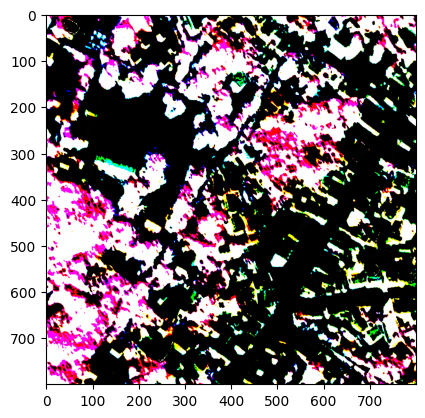

In [23]:
plt.imshow(image.permute(1,2,0).numpy().astype('uint8'))